PERGUNTA 04: Qual canal de aquisição gerou o maior volume de leads?




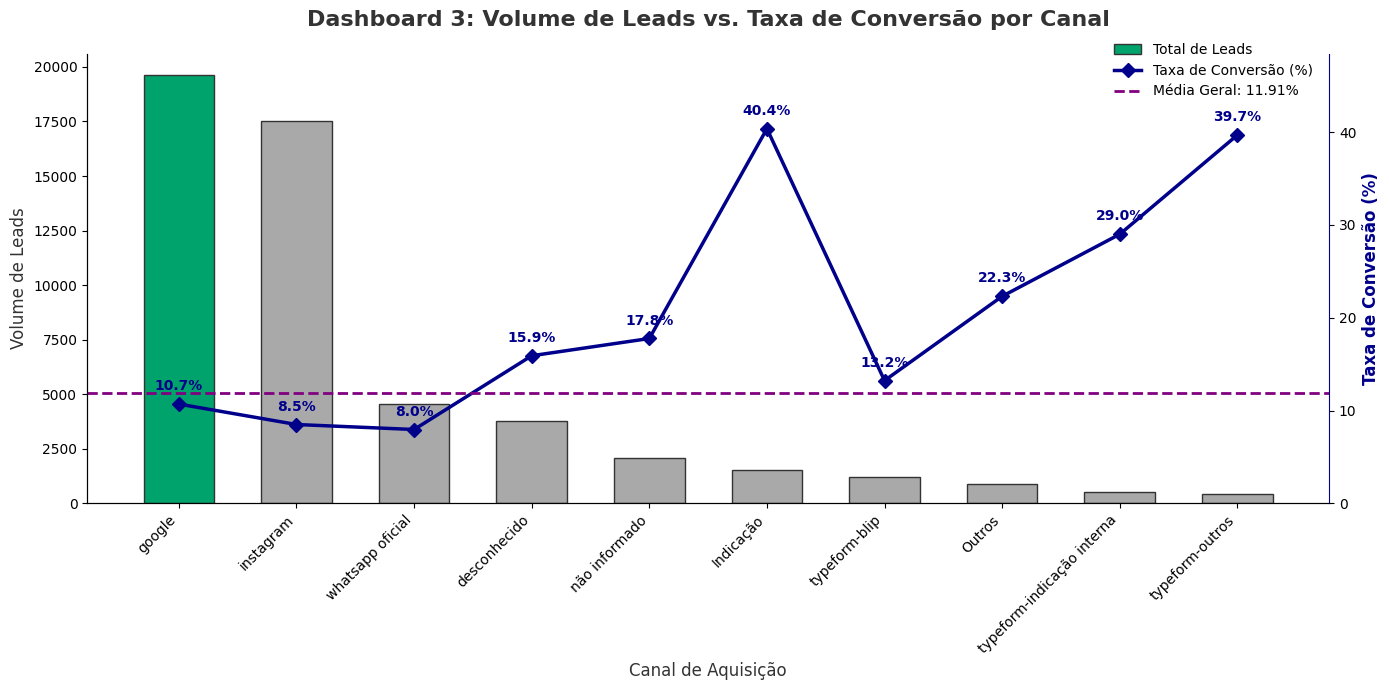


--- Respostas de Negócio ---
Canal com maior volume de leads: google
Canal com melhor Taxa de Conversão: Indicação


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 


COLOR_HIGHLIGHT_VOLUME = '#00A36C' 
COLOR_BAR_DEFAULT = '#A9A9A9'      
COLOR_CONVERSION_LINE = '#00008B'  
COLOR_AVG_LINE = '#800080'         
TEXT_COLOR = '#333333'            
WHITE = '#FFFFFF'                  


BASE_PATH = Path("../processed")
FILE_NAME = "leads_limpo.csv"

try:
    leads = pd.read_csv(BASE_PATH / FILE_NAME)
except FileNotFoundError:
    print(f"O arquivo '{FILE_NAME}' não foi encontrado.")
    print(f"Verifique se o caminho '{BASE_PATH / FILE_NAME}' está correto em sua estrutura de pastas.")
    raise


leads['utm_source'] = leads['utm_source'].fillna('Não Informado/Vazio').str.lower()
leads.loc[leads['utm_source'].str.contains('indicacao|gentileza|ex membro', na=False), 'utm_source'] = 'Indicação'

# Contagem de Leads e Contratos (Vendas) por Canal
df_canais = leads.groupby('utm_source').agg(
    total_leads=('lead_id', 'nunique'),
    leads_vendidos=('status_final', lambda x: (x == 'VENDIDO').sum())
).reset_index()

# Calcular a Taxa de Conversão
# Evita divisão por zero
df_canais['taxa_conversao'] = df_canais.apply(
    lambda row: row['leads_vendidos'] / row['total_leads'] if row['total_leads'] > 0 else 0,
    axis=1
)

# Filtrar Top N canais (ex: Top 10) e agrupar o resto em 'Outros'
N = 10 
df_canais_sorted = df_canais.sort_values(by='total_leads', ascending=False)
top_canais = df_canais_sorted.head(N-1)['utm_source'].tolist()

# Agrupar canais menores em 'Outros'
df_canais_filtered = df_canais_sorted[df_canais_sorted['utm_source'].isin(top_canais)].copy()
df_outros = df_canais_sorted[~df_canais_sorted['utm_source'].isin(top_canais)].sum(numeric_only=True)

if len(df_canais_sorted) > N:
    df_outros['utm_source'] = 'Outros'
    # Recalcula a taxa de conversão para 'Outros'
    df_outros['taxa_conversao'] = df_outros['leads_vendidos'] / df_outros['total_leads'] if df_outros['total_leads'] > 0 else 0
    df_canais_final = pd.concat([df_canais_filtered, pd.DataFrame([df_outros])], ignore_index=True)
else:
    df_canais_final = df_canais_sorted.copy()
    
df_canais_final = df_canais_final.sort_values(by='total_leads', ascending=False).reset_index(drop=True)

# Identificar o canal com maior volume para destaque
canal_maior_volume = df_canais_final.iloc[0]['utm_source']

# Criar lista de cores para as barras
cores_barra = [COLOR_HIGHLIGHT_VOLUME if canal == canal_maior_volume else COLOR_BAR_DEFAULT
               for canal in df_canais_final['utm_source']]


# 2. Geração do Gráfico (Volume vs. Conversão) ---

fig, ax1 = plt.subplots(figsize=(14, 7), facecolor=WHITE)
largura = 0.6 # Largura das barras

# Eixo 1: Volume de Leads (Barra)
ax1.bar(df_canais_final['utm_source'], df_canais_final['total_leads'], 
        color=cores_barra, edgecolor=TEXT_COLOR, linewidth=1, label='Total de Leads', width=largura)
ax1.set_xlabel('Canal de Aquisição', fontsize=12, color=TEXT_COLOR)
ax1.set_ylabel('Volume de Leads', fontsize=12, color=TEXT_COLOR)

ax1.tick_params(axis='x', rotation=45) 
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='y', left=False) 

# Ajustando a rotação e alinhamento usando plt.xticks (fora do ax.tick_params)
plt.xticks(rotation=45, ha='right')

# Eixo 2: Taxa de Conversão (Linha)
ax2 = ax1.twinx()
ax2.plot(df_canais_final['utm_source'], df_canais_final['taxa_conversao'] * 100, 
          color=COLOR_CONVERSION_LINE, marker='D', markersize=7, linestyle='-', linewidth=2.5, label='Taxa de Conversão (%)') # Aumentando linewidth e markersize
ax2.set_ylabel('Taxa de Conversão (%)', fontsize=12, color=COLOR_CONVERSION_LINE, fontweight='bold') # Destaque na cor do label
ax2.set_ylim(0, df_canais_final['taxa_conversao'].max() * 100 * 1.2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color(COLOR_CONVERSION_LINE) # Destaque na cor do eixo

# Linha da Taxa de Conversão Média Geral (referência)
media_geral = df_canais['leads_vendidos'].sum() / df_canais['total_leads'].sum()
ax2.axhline(media_geral * 100, color=COLOR_AVG_LINE, linestyle='--', linewidth=2, # Alterado para pontilhado mais grosso
             label=f'Média Geral: {media_geral * 100:.2f}%')

# Título
plt.title('Dashboard 3: Volume de Leads vs. Taxa de Conversão por Canal', 
          fontsize=16, color=TEXT_COLOR, fontweight='bold', pad=20)

# Adicionar rótulos de conversão nos pontos
for i, (canal, tx) in enumerate(zip(df_canais_final['utm_source'], df_canais_final['taxa_conversao'] * 100)):
    # Cor do rótulo da conversão é a mesma da linha
    ax2.annotate(f'{tx:.1f}%', (i, tx), textcoords="offset points", xytext=(0, 10), 
                 ha='center', fontsize=10, fontweight='bold', color=COLOR_CONVERSION_LINE) 

# Legendas
fig.legend(loc="upper right", bbox_to_anchor=(0.95, 0.95), frameon=False, fontsize=10) # Posicionando melhor a legenda
plt.tight_layout()
plt.show()

print("\n--- Respostas de Negócio ---")
canal_maior_volume = df_canais_final.iloc[0]['utm_source']
canal_melhor_conversao = df_canais_final.sort_values(by='taxa_conversao', ascending=False).iloc[0]['utm_source']
print(f"Canal com maior volume de leads: {canal_maior_volume}")
print(f"Canal com melhor Taxa de Conversão: {canal_melhor_conversao}")

PERGUNTA 03: Qual a taxa de conversão geral em venda dos leads da Livance?


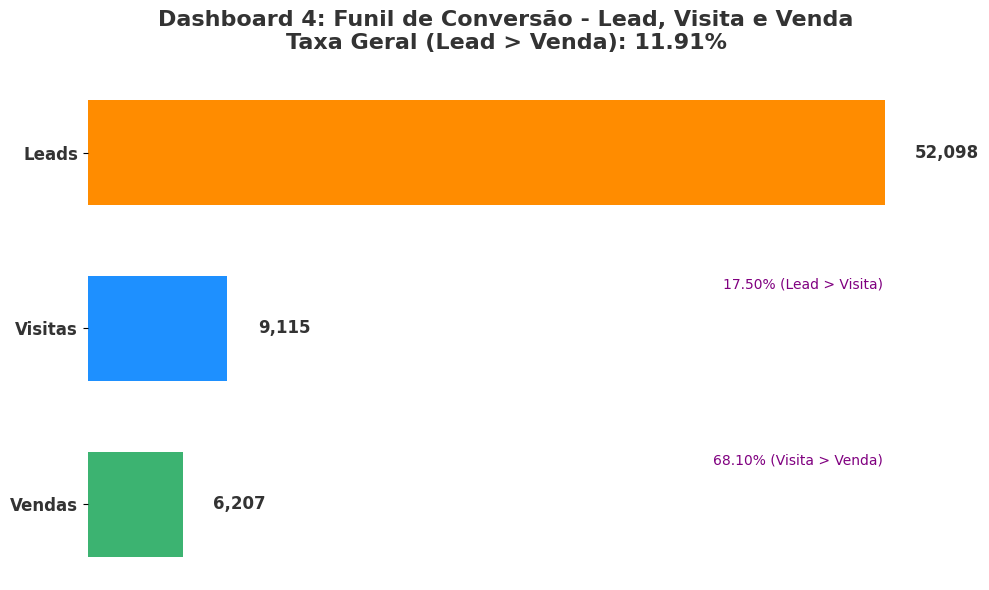


--- Respostas de Negócio ---
Taxa de Conversão Geral (Lead -> Venda): 11.91%
Taxa de Conversão Lead -> Visita: 17.50%
Taxa de Conversão Visita -> Venda: 68.10%


In [ ]:
COLOR_LEADS = '#FF8C00' 
COLOR_VISITAS = '#1E90FF' 
COLOR_VENDAS = '#3CB371' 
TEXT_COLOR = '#333333' 
CONVERSION_RATE_COLOR = '#800080' 
WHITE = '#FFFFFF' 


# KPI 1: Total de Leads (Topo do Funil)
total_leads = leads['lead_id'].nunique()

# KPI 2: Total de Visitas (Contagem de visitas_limpo)
# Usei 'id_visita' para contar visitas únicas
total_visitas = visitas['id_visita'].nunique()

# KPI 3: Total de Vendas (Contagem de leads vendidos)
# Usei leads com status_final = VENDIDO
total_vendas = leads[leads['status_final'] == 'VENDIDO']['lead_id'].nunique()


# Estrutura do Funil
funil_data = pd.DataFrame({
    'Estágio': ['Leads', 'Visitas', 'Vendas'],
    'Volume': [total_leads, total_visitas, total_vendas]
})

# --- 3. Cálculo das Taxas de Conversão ---


taxa_lead_visita = (total_visitas / total_leads * 100) if total_leads > 0 else 0


taxa_visita_venda = (total_vendas / total_visitas * 100) if total_visitas > 0 else 0

#
taxa_geral = (total_vendas / total_leads * 100) if total_leads > 0 else 0

taxas_conversao_text = [
    f'N/A', # Leads (100% do volume inicial)
    f'{taxa_lead_visita:.2f}% (Lead > Visita)',
    f'{taxa_visita_venda:.2f}% (Visita > Venda)'
]

colors = [COLOR_LEADS, COLOR_VISITAS, COLOR_VENDAS]

# Geração do Gráfico de Funil

fig, ax = plt.subplots(figsize=(10, 6), facecolor=WHITE)
y_pos = range(len(funil_data))

for i, (volume, color) in enumerate(zip(funil_data['Volume'], colors)):
    ax.barh(y_pos[i], volume, color=color, height=0.6)

# Estilização
ax.set_yticks(y_pos)
ax.set_yticklabels(funil_data['Estágio'], fontsize=12, fontweight='bold', color=TEXT_COLOR)
ax.invert_yaxis()  # Estágios do funil de cima para baixo
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', length=0) # Remover ticks do eixo X
ax.set_xticklabels([]) # Remover labels do eixo X


for i, (volume, taxa) in enumerate(zip(funil_data['Volume'], taxas_conversao_text)):
    # Rótulo do Volume (à direita da barra)
    ax.text(volume + 2000, i, f'{volume:,.0f}', 
            va='center', ha='left', fontsize=12, color=TEXT_COLOR, fontweight='bold')
    
    # Rótulo da Taxa de Conversão (abaixo da barra - apenas para Visitas e Vendas)
    if i > 0:
        # A taxa é a conversão do estágio anterior para o atual
        ax.text(ax.get_xlim()[1] * 0.95, i - 0.25, taxa, 
                va='center', ha='right', fontsize=10, color=CONVERSION_RATE_COLOR, 
                bbox=dict(facecolor=WHITE, alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

# Título
ax.set_title(
    f'Dashboard 4: Funil de Conversão - Lead, Visita e Venda\nTaxa Geral (Lead > Venda): {taxa_geral:.2f}%', 
    fontsize=16, color=TEXT_COLOR, fontweight='bold', pad=20
)

plt.tight_layout()
plt.show()

print("\n--- Respostas de Negócio ---")
print(f"Taxa de Conversão Geral (Lead -> Venda): {taxa_geral:.2f}%")
print(f"Taxa de Conversão Lead -> Visita: {taxa_lead_visita:.2f}%")
print(f"Taxa de Conversão Visita -> Venda: {taxa_visita_venda:.2f}%")

PERGUNTA 01: Qual foi o atingimento médio da meta de vendas entre Abr/24 e Abr/25?

In [ ]:
base = Path("../processed")
geral = pd.read_csv(base / "geral_limpo.csv")

# ... (Seu código de seleção de linhas e colunas) ...
linha_meta = geral[geral["metrica"] == "Vendas"].iloc[0]
linha_real = geral[geral["metrica"] == "Vendas"].iloc[1]

colunas_periodo = [
    col for col in geral.columns
    if "2024-" in col or "2025-" in col
]
colunas_periodo = [c for c in colunas_periodo if "2024-04" <= c <= "2025-03"]

meta = linha_meta[colunas_periodo].astype(float)
realizado = linha_real[colunas_periodo].astype(float)

realizado_total = realizado.sum()
meta_total = meta.sum()
atingimento_medio = realizado_total / meta_total
# ------------------------------------------


# 1. Criar o DataFrame de Visualização (df_dashboard)
df_dashboard = pd.DataFrame({
    'Mes_Ano': colunas_periodo,
    'Meta': meta.values,
    'Realizado': realizado.values,
})

# 2. Calcular o Atingimento Mensal
df_dashboard['Atingimento_%'] = (df_dashboard['Realizado'] / df_dashboard['Meta']) * 100

# 3. Converter a coluna de mês para datetime para ordenação correta no plot
df_dashboard['Mes_Ano'] = pd.to_datetime(df_dashboard['Mes_Ano'])

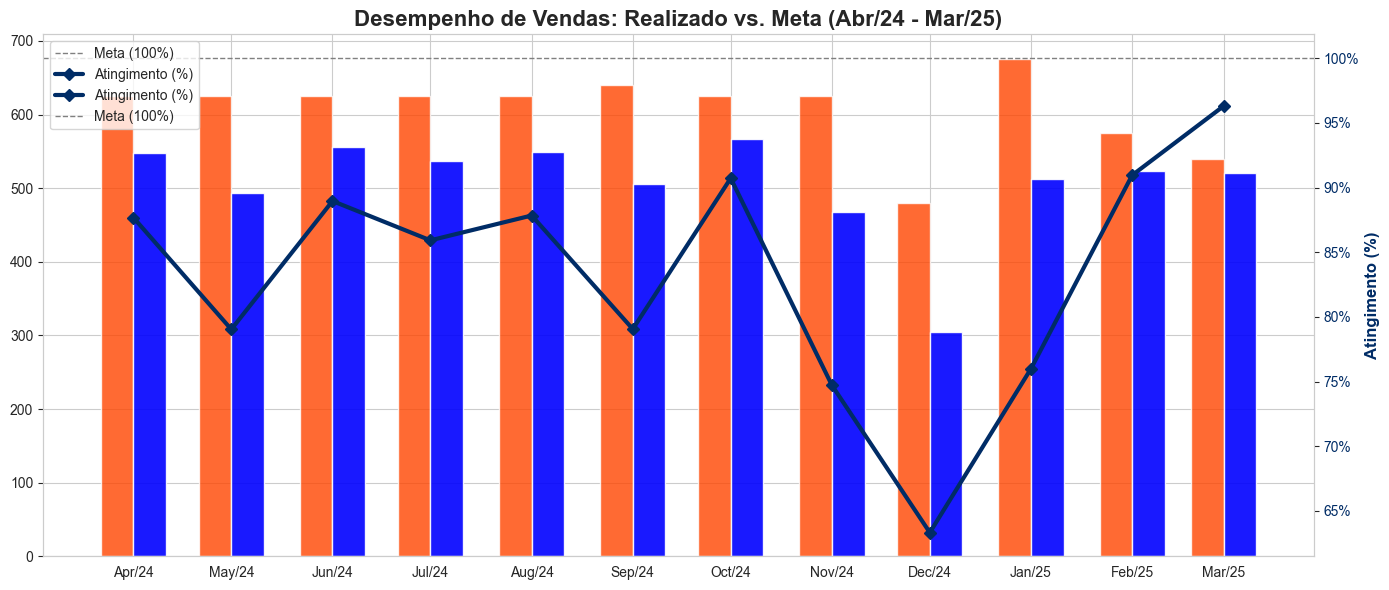

In [ ]:
AZUL_MAXIMO = '#0000FF'    
LARANJA_MAXIMO = '#FF4500' 
AZUL_MARINHO = '#002C66'   
CINZA_REFERENCIA = 'gray'  

# Métrica Principal (KPI)

plt.figure(figsize=(14, 6))

# Gráfico de Barras para Realizado e Meta
bar_width = 10
x = df_dashboard['Mes_Ano']

# Barras de Meta (Laranja Máximo)
plt.bar(x - pd.Timedelta(days=bar_width/2), df_dashboard['Meta'], width=bar_width, 
        label='Meta', color=LARANJA_MAXIMO, alpha=0.8)
# Barras de Realizado (Azul Máximo)
plt.bar(x + pd.Timedelta(days=bar_width/2), df_dashboard['Realizado'], width=bar_width, 
        label='Realizado', color=AZUL_MAXIMO, alpha=0.9)

# Configuração do Eixo Secundário para o Atingimento
ax2 = plt.gca().twinx()
# Linha de Atingimento (Azul Escuro/Marinho)
ax2.plot(x, df_dashboard['Atingimento_%'], marker='D', linestyle='-', color=AZUL_MARINHO, 
         label='Atingimento (%)', linewidth=3)
# Linha de 100% (Cinza)
ax2.axhline(100, color=CINZA_REFERENCIA, linestyle='--', linewidth=1, label='Meta (100%)') 

# Formatação
plt.title(f'Desempenho de Vendas: Realizado vs. Meta (Abr/24 - Mar/25)', fontsize=16, fontweight='bold')
plt.xlabel('Mês', fontsize=12)

# Eixo Primário (Vendas)
plt.gca().set_ylabel('Valor (Vendas)', color='black', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.gca().tick_params(axis='y', labelcolor='black')

# Eixo Secundário (Atingimento)
ax2.set_ylabel('Atingimento (%)', color=AZUL_MARINHO, fontsize=12, fontweight='bold')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
ax2.tick_params(axis='y', labelcolor=AZUL_MARINHO)
ax2.grid(False)

# Legendas combinadas e ordenadas
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend_lines = [lines[1], lines[0], lines2[0], lines2[1]] # Realizado, Meta, Atingimento, 100%
legend_labels = [labels[1], labels[0], labels2[0], labels2[1]]

ax2.legend(legend_lines, legend_labels, loc='upper left', frameon=True)

plt.xticks(x, [date.strftime('%b/%y') for date in x], rotation=45, ha='right')
plt.tight_layout()
plt.show()